In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/unet

/content/drive/MyDrive/unet


In [3]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Load dataset

In [4]:
r = open('trainval.txt')
txt = r.read().split('\n')
r.close()
txt = txt[:-1]

name = []
species = []
for line in txt:
    line = line.split(' ')
    name.append(line[0])
    species.append(int(line[2]))

name_train, name_test = train_test_split(name, test_size=0.2, random_state=42)
name_train, name_valid = train_test_split(name_train, test_size=0.1, random_state=42)

In [5]:
img_path = 'images/'
mask_path = 'trimaps/'

In [6]:
def load_img(path, name):
    X = []
    count = 0
    while count < len(name):
        temp_x = []
        temp_name = []
        if count+200 < len(name):
            temp_name = name[count:count+200]
        else:
            temp_name = name[count:]
        
        cnt = 0
        for img in temp_name:
            x = cv2.imread(path+img+'.jpg', cv2.IMREAD_COLOR)
            x = cv2.resize(x, (224, 224))
            x = x.astype(np.float)
            x = np.reshape(x, (1, 224, 224, 3))
            if cnt == 0:
                temp_x = x
            else:
                temp_x = np.concatenate((temp_x, x), axis=0)
            cnt += 1
        if count == 0:
            X = temp_x
        else:
            X = np.concatenate((X, temp_x), axis=0)
        
        count += 200
        print(X.shape)

    return X/255

In [7]:
def load_mask(path, name):
    Y = []
    count = 0
    while count < len(name):
        temp_y = []
        temp_name = []
        temp_species = []
        if count+200 < len(name):
            temp_name = name[count:count+200]
            temp_species = species[count:count+200]
        else:
            temp_name = name[count:]
            temp_species = species[count:count+200]
        
        cnt = 0
        for k in range(len(temp_name)):
            y = cv2.imread(path+temp_name[k]+'.png', cv2.IMREAD_GRAYSCALE)
            y = cv2.resize(y, (224, 224))
            
            # 1: cat, 0: dog, 2: background
            if temp_species[k] == 1:
                y = np.where(y != 3, y, 1)
                for i in range(y.shape[0]):
                    for j in range(y.shape[1]):
                        if y[i][j] == 3:
                            y[i][j] = 1
            else:
                y = np.where(y == 2, y, 0)
                for i in range(y.shape[0]):
                    for j in range(y.shape[1]):
                        if y[i][j] == 3 or y[i][j] == 1:
                            y[i][j] = 0
            
            y = y.astype(np.int)
            y = np.reshape(y, (1, 224, 224))
            if cnt == 0:
                temp_y = y
            else:
                temp_y = np.concatenate((temp_y, y), axis=0)
            cnt += 1
        if count == 0:
            Y = temp_y
        else:
            Y = np.concatenate((Y, temp_y), axis=0)
        
        count += 200
        print(Y.shape)

    return Y

In [8]:
X = load_img(img_path, name)
y = load_mask(mask_path, name)

(200, 224, 224, 3)
(400, 224, 224, 3)
(600, 224, 224, 3)
(800, 224, 224, 3)
(1000, 224, 224, 3)
(1200, 224, 224, 3)
(1400, 224, 224, 3)
(1600, 224, 224, 3)
(1800, 224, 224, 3)
(2000, 224, 224, 3)
(2200, 224, 224, 3)
(2400, 224, 224, 3)
(2600, 224, 224, 3)
(2800, 224, 224, 3)
(3000, 224, 224, 3)
(3200, 224, 224, 3)
(3400, 224, 224, 3)
(3600, 224, 224, 3)
(3680, 224, 224, 3)
(200, 224, 224)
(400, 224, 224)
(600, 224, 224)
(800, 224, 224)
(1000, 224, 224)
(1200, 224, 224)
(1400, 224, 224)
(1600, 224, 224)
(1800, 224, 224)
(2000, 224, 224)
(2200, 224, 224)
(2400, 224, 224)
(2600, 224, 224)
(2800, 224, 224)
(3000, 224, 224)
(3200, 224, 224)
(3400, 224, 224)
(3600, 224, 224)
(3680, 224, 224)


In [9]:
X_train = X[:2650]
y_train = y[:2650]

X_valid = X[2650:2944]
y_valid = y[2650:2944]

X_test = X[2944:]
y_test = y[2944:]

# Hyperparameter

In [10]:
shape = (224, 224, 3)
num_classes = 3
lr = 1e-4
batch_size = 4
epochs = 30

In [11]:
callbacks_unet = [
    ModelCheckpoint("unet.h5", save_best_model=True),
    ReduceLROnPlateau(monitor="val_loss", patience=3, factor=0.1, verbose=1),
    EarlyStopping(patience=5, restore_best_weights=True)
]

# Metrics function

In [12]:
def visualize(image, predicted_mask, ground_truth):
    figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 4))
    ax[0].imshow(image)
    ax[0].set_title('Image')
    ax[0].set_axis_off()

    ax[1].imshow(predicted_mask)
    ax[1].set_title('Predicted mask')
    ax[1].set_axis_off()

    ax[2].imshow(ground_truth)
    ax[2].set_title('Ground truth')
    ax[2].set_axis_off()

    plt.show()

In [13]:
def iou(y_test, pred, type_pet):
    intersection = 0
    union = 0
    for i in range(y_test.shape[0]):
        for h in range(y_test.shape[1]):
            for w in range(y_test.shape[2]):
                if y_test[i][h][w] == type_pet or pred[i][h][w] == type_pet:
                    union += 1
                if y_test[i][h][w] == type_pet and pred[i][h][w] == type_pet:
                    intersection += 1
        
    return intersection / union

In [14]:
def dice(y_test, pred, type_pet):
    gt_area = 0
    pr_area = 0
    intersection = 0
    for i in range(y_test.shape[0]):
        for h in range(y_test.shape[1]):
            for w in range(y_test.shape[2]):
                if y_test[i][h][w] == type_pet:
                    gt_area += 1
                if pred[i][h][w] == type_pet:
                    pr_area += 1
                if y_test[i][h][w] == type_pet and pred[i][h][w] == type_pet:
                    intersection += 1
    return 2 * intersection / (gt_area + pr_area)

# Unet

## Define Model

In [15]:
def conv_block(inputs, filters, pool=True):
    x = Conv2D(filters, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    if pool == True:
        p = MaxPool2D((2, 2))(x)
        return x, p
    else:
        return x

In [16]:
def unet(shape, num_classes):
    inputs = Input(shape)

    x1, p1 = conv_block(inputs, 16, pool=True)
    x2, p2 = conv_block(p1, 32, pool=True)
    x3, p3 = conv_block(p2, 48, pool=True)
    x4, p4 = conv_block(p3, 64, pool=True)

    b1 = conv_block(p4, 128, pool=False)

    u1 = UpSampling2D((2, 2), interpolation="bilinear")(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, 64, pool=False)

    u2 = UpSampling2D((2, 2), interpolation="bilinear")(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, 48, pool=False)

    u3 = UpSampling2D((2, 2), interpolation="bilinear")(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 32, pool=False)

    u4 = UpSampling2D((2, 2), interpolation="bilinear")(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, 16, pool=False)

    output = Conv2D(num_classes, 1, padding="same", activation="softmax")(x8)

    return Model(inputs, output)

In [17]:
unet_model = unet(shape, num_classes)
unet_model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr), metrics=['accuracy'])
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 16  448         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

## Training

In [18]:
history = unet_model.fit(x=X_train, y=y_train,
                         batch_size=batch_size,
                         validation_data=(X_valid, y_valid),
                         epochs=epochs, callbacks=callbacks_unet)

Epoch 1/30
663/663 [==============================] - 82s 105ms/step - loss: 0.7931 - accuracy: 0.6553 - val_loss: 0.8472 - val_accuracy: 0.6614 - lr: 1.0000e-04
Epoch 2/30
663/663 [==============================] - 67s 101ms/step - loss: 0.6570 - accuracy: 0.7242 - val_loss: 0.5766 - val_accuracy: 0.7649 - lr: 1.0000e-04
Epoch 3/30
663/663 [==============================] - 67s 101ms/step - loss: 0.6110 - accuracy: 0.7430 - val_loss: 0.5995 - val_accuracy: 0.7489 - lr: 1.0000e-04
Epoch 4/30
663/663 [==============================] - 67s 101ms/step - loss: 0.5751 - accuracy: 0.7584 - val_loss: 0.6058 - val_accuracy: 0.6981 - lr: 1.0000e-04
Epoch 5/30
663/663 [==============================] - 67s 101ms/step - loss: 0.5494 - accuracy: 0.7715 - val_loss: 0.4939 - val_accuracy: 0.8010 - lr: 1.0000e-04
Epoch 6/30
663/663 [==============================] - 67s 101ms/step - loss: 0.5234 - accuracy: 0.7849 - val_loss: 0.5675 - val_accuracy: 0.7405 - lr: 1.0000e-04
Epoch 7/30
663/663 [========

## Result

In [19]:
unet_model = tf.keras.models.load_model('unet.h5')
pred = unet_model.predict(X_test)
pred = np.argmax(pred, axis=3)

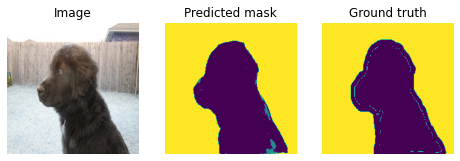

In [20]:
visualize(X_test[20], pred[20], y_test[20])

In [21]:
iou_cat = iou(y_test, pred, 1)
iou_dog = iou(y_test, pred, 0)
iou_bg = iou(y_test, pred, 2)

print(f'IOU cat: {iou_cat:.4f}')
print(f'IOU dog: {iou_dog:.4f}')

IOU cat: 0.3896
IOU dog: 0.5468


In [22]:
dice_cat = dice(y_test, pred, 1)
dice_dog = dice(y_test, pred, 0)
dice_bg = dice(y_test, pred, 2)

print(f'Dice cat: {dice_cat:.4f}')
print(f'Dice dog: {dice_dog:.4f}')

Dice cat: 0.5607
Dice dog: 0.7070


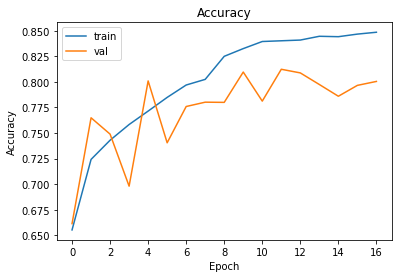

In [23]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

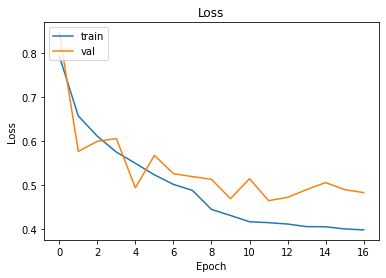

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()